<a href="https://colab.research.google.com/github/shroffp05/msca-37011-deep-learning/blob/main/Team1_Project_Notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/Dataset

Mild_Demented  Moderate_Demented  Non_Demented	Very_Mild_Demented


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, InputLayer, BatchNormalization
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
from keras import applications
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
%matplotlib inline

In [ ]:
%cd drive/MyDrive/Dataset/

/content/drive/MyDrive/Dataset


In [ ]:
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
num_classes = 4

In [ ]:
IMG_WIDTH=128
IMG_HEIGHT=128

In [ ]:
def create_dataset():
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in classes:
        for file in os.listdir(os.path.join(dir1)):
            image_path= os.path.join(dir1,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name = create_dataset()

## Section 1: Augmenting Dataset

In [ ]:
mild_demented_images = img_data[:897]
moderate_demented_images = img_data[897:961]
non_demented_images = img_data[961:4161]
very_mild_demented_images = img_data[4161:6401]

label_mild_demented = class_name[:897]
label_moderate_demented = class_name[:961]
label_non_demented = class_name[:4161]
label_very_mild_demented = class_name[:6401]

In [ ]:
seq = iaa.Sequential([

    iaa.Crop(percent=(0, 0.1)), # random crops
  
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.0001*255), per_channel=0.5),
], random_order=True) # apply augmenters in random order 

In [ ]:
images_aug_mild_demented = [seq(images=mild_demented_images) for i in range(3)]

images_aug_mild_demented_1 = []
for i in range(len(images_aug_mild_demented)):
  for j in range(len(images_aug_mild_demented[i])):
    images_aug_mild_demented_1.append(images_aug_mild_demented[i][j])

images_aug_moderate_demented = [seq(images=moderate_demented_images) for i in range(49)]

In [ ]:
images_aug_moderate_demented_1 = []
for i in range(len(images_aug_moderate_demented)):
  for j in range(len(images_aug_moderate_demented[i])):
    images_aug_moderate_demented_1.append(images_aug_moderate_demented[i][j])

images_aug_very_mild_demented_1 = seq(images=very_mild_demented_images)

mild_demented_images = mild_demented_images + images_aug_mild_demented_1
moderate_demented_images = moderate_demented_images + images_aug_moderate_demented_1
very_mild_demented_images = very_mild_demented_images + images_aug_very_mild_demented_1

In [ ]:
mild_demented_images = mild_demented_images[:3200]
very_mild_demented_images = very_mild_demented_images[:3200]

images_final_data = mild_demented_images + moderate_demented_images + non_demented_images + very_mild_demented_images

labels_data = [0 for i in range(3200)] + [1 for i in range(3200)] + [2 for i in range(3200)] + [3 for i in range(3200)]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(images_final_data, np.float32), np.array(labels_data, np.float32), 
                                                    test_size=0.3)


In [ ]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 128, 128)
    X_test = X_test.reshape(np.array(X_test).shape[0], 1, 128, 128)
    input_shape = (1, 128, 128)
else:
    X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
    X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
    input_shape = (128, 128, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (8960, 128, 128, 1)
x_test shape: (3840, 128, 128, 1)
8960 train samples
3840 test samples
y_train shape: (8960, 4)
y_test shape: (3840, 4)


## VGG 19 Model 

In [ ]:
model = keras.applications.VGG19(weights = None, include_top=False, input_shape = (128, 128, 1))

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
for layer in model.layers[:20]:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input, predictions)

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# compile the model 
adam = keras.optimizers.Adam(learning_rate=0.01)
model_final.compile(loss = "categorical_crossentropy", optimizer = adam, metrics=["accuracy"])

In [ ]:
# Fit model
epochs = 10 #0
batch_size=128
history = model_final.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test,y_test),shuffle=True)

Epoch 1/10
70/70 [==============================] - 2360s 34s/step - loss: 1.3956 - accuracy: 0.2463 - val_loss: 1.3870 - val_accuracy: 0.2484
Epoch 2/10
70/70 [==============================] - 2357s 34s/step - loss: 1.3871 - accuracy: 0.2478 - val_loss: 1.3868 - val_accuracy: 0.2484
Epoch 3/10
70/70 [==============================] - 2350s 34s/step - loss: 1.3869 - accuracy: 0.2529 - val_loss: 1.3866 - val_accuracy: 0.2531
Epoch 4/10
70/70 [==============================] - 2357s 34s/step - loss: 1.3866 - accuracy: 0.2453 - val_loss: 1.3863 - val_accuracy: 0.2464
Epoch 5/10
70/70 [==============================] - 2354s 34s/step - loss: 1.3868 - accuracy: 0.2501 - val_loss: 1.3871 - val_accuracy: 0.2484
Epoch 6/10
70/70 [==============================] - 2352s 34s/step - loss: 1.3865 - accuracy: 0.2510 - val_loss: 1.3863 - val_accuracy: 0.2521
Epoch 7/10
70/70 [==============================] - 2353s 34s/step - loss: 1.3866 - accuracy: 0.2508 - val_loss: 1.3866 - val_accuracy: 0.2484

Text(0.5, 1.0, 'Loss Curves')

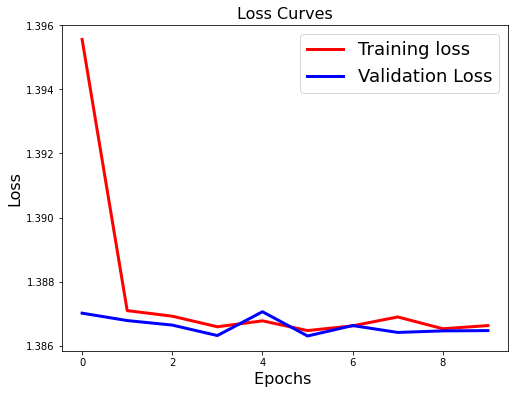

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
predict_x=model_final.predict(X_test) 
predicted_classes=np.argmax(predict_x,axis=1)

In [ ]:
pred_value_2 = keras.utils.to_categorical(predicted_classes, num_classes)

In [ ]:
# Check which items we got right / wrong
correct_indices = np.nonzero(pred_value_2 == y_test)[0]
incorrect_indices = np.nonzero(pred_value_2 != y_test)[0]

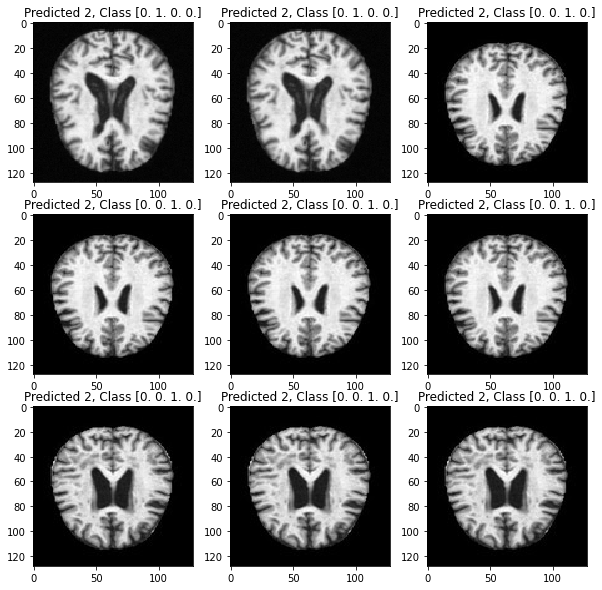

In [ ]:
#some of the correct results
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(128,128), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

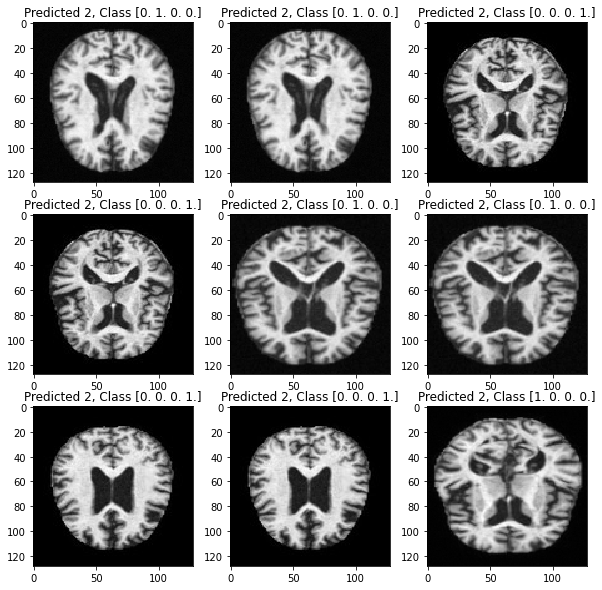

In [ ]:
#some of the incorrect predictions
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(128,128), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))